In [1]:
#Importing all the necessary libraries
from matplotlib import pyplot
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import pickle
import sys
from glob import glob  
import math
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Pre-processing and Cleaning

In [4]:
df=pd.read_csv("path_to_add/MIDAS_Task3/Datasets/flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.csv",index_col=0) #Please add path_to_add that is required for your local Machine
df=df.reset_index(drop=True)
df.columns

Index(['crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [ ]:
#Reducing the dataframe to just the necessary columns
df=df.loc[:,['description','image','product_category_tree']]

Extracting the primary category for each row using basic string processing.                                                                     
For eg:                                                                              
**"Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"** becomes **"Clothing"**

In [ ]:
labels=[]
for i in range(len(df)):
  tempString=df.loc[i,"product_category_tree"]
  labels.append(tempString[2:tempString.find(">")-1])
df['Label']=labels

The labels that had a frequency <=10 were removed which led to a reduction of **238** labels and **342** entries from the dataset.

The final number of classes in the dataset are **27** now  

In [ ]:
labelOccuranceMap=Counter(labels)
labelsToBeRemoved=[]
for key,value in labelOccuranceMap.items():
  if (value<=10):
    labelsToBeRemoved.append(key)

len(labelsToBeRemoved)

238

In [ ]:
#Removing the labels present in labelsToBeRemoved
df=df.query('Label not in @labelsToBeRemoved')
df=df.reset_index(drop=True)
df

,description,image,product_category_tree,Label
0,Key Features of Alisha Solid Women's Cycling S...,"[""http://img5a.flixcart.com/image/short/u/4/a/...","[""Clothing >> Women's Clothing >> Lingerie, Sl...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...","[""Furniture >> Living Room Furniture >> Sofa B...",Furniture
2,Key Features of AW Bellies Sandals Wedges Heel...,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...","[""Footwear >> Women's Footwear >> Ballerinas >...",Footwear
3,Key Features of Alisha Solid Women's Cycling S...,"[""http://img5a.flixcart.com/image/short/6/2/h/...","[""Clothing >> Women's Clothing >> Lingerie, Sl...",Clothing
4,Specifications of Sicons All Purpose Arnica Do...,"[""http://img5a.flixcart.com/image/pet-shampoo/...","[""Pet Supplies >> Grooming >> Skin & Coat Care...",Pet Supplies
...,...,...,...,...
19653,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,"[""http://img6a.flixcart.com/image/wall-decorat...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
19654,Buy Wallmantra Large Vinyl Stickers Sticker fo...,"[""http://img6a.flixcart.com/image/sticker/z/g/...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
19655,Buy Elite Collection Medium Acrylic Sticker fo...,"[""http://img5a.flixcart.com/image/sticker/b/s/...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care
19656,Buy Elite Collection Medium Acrylic Sticker fo...,"[""http://img5a.flixcart.com/image/sticker/4/2/...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care


Label Encoder from sklearn was used to encode the string labels into integers

In [ ]:
from sklearn import preprocessing
labelEncoder=preprocessing.LabelEncoder()
encodedLabelList=(labelEncoder.fit_transform(df['Label']))
df['Label']=encodedLabelList

In [ ]:
df.to_csv("path_to_add/MIDAS_Task3/Datasets/Task3_Cleaned.csv") #Please add path_to_add that is required for your local Machine
df

,description,image,product_category_tree,Label
0,Key Features of Alisha Solid Women's Cycling S...,"[""http://img5a.flixcart.com/image/short/u/4/a/...","[""Clothing >> Women's Clothing >> Lingerie, Sl...",5
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...","[""Furniture >> Living Room Furniture >> Sofa B...",8
2,Key Features of AW Bellies Sandals Wedges Heel...,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...","[""Footwear >> Women's Footwear >> Ballerinas >...",7
3,Key Features of Alisha Solid Women's Cycling S...,"[""http://img5a.flixcart.com/image/short/6/2/h/...","[""Clothing >> Women's Clothing >> Lingerie, Sl...",5
4,Specifications of Sicons All Purpose Arnica Do...,"[""http://img5a.flixcart.com/image/pet-shampoo/...","[""Pet Supplies >> Grooming >> Skin & Coat Care...",20
...,...,...,...,...
19653,Buy WallDesign Small Vinyl Sticker for Rs.730 ...,"[""http://img6a.flixcart.com/image/wall-decorat...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",1
19654,Buy Wallmantra Large Vinyl Stickers Sticker fo...,"[""http://img6a.flixcart.com/image/sticker/z/g/...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",1
19655,Buy Elite Collection Medium Acrylic Sticker fo...,"[""http://img5a.flixcart.com/image/sticker/b/s/...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",1
19656,Buy Elite Collection Medium Acrylic Sticker fo...,"[""http://img5a.flixcart.com/image/sticker/4/2/...","[""Baby Care >> Baby & Kids Gifts >> Stickers >...",1


# Extraction of Images for the MultiModal Model

It is advised to not run this section's cells on your local machine. We have provided a drive link which will help you download the zip file comprising of all the images. And all the csv files are also present in the Datasets Folder in the GitHub Repository

Drive Link for Task3_Images.zip: https://drive.google.com/file/d/1q65iLdSOSsqQxtRnW8I6DCNOTZNao7K4/view?usp=sharing


In [ ]:
#Extracting the indices which had an nan value for the image column
for i in range(len(list(pd.isna(df['image'])))):
  if(list(pd.isna(df['image']))[i]==True):
    print(i)

8488
8796
8831


The image column in the dataset has a product-image link for almost every row. Intutively it made sense to combine both the text and vision modalities to achieve better results.

---

The requests module along with basic string processing was used to code the following snippet which would download the product-image if the image link is valid.All the images were stored in the google drive and later used with the MultiModal Model.

In [ ]:
dataframe=pd.read_csv("/content/drive/MyDrive/MIDAS Task/Task3_Cleaned.csv",index_col=0)
dataframe=dataframe.reset_index(drop=True)
imgPathList=[np.nan]*20000

def extractImages(df,imgPathList):
  for i in range(len(df)):
    if (i==8488 or i==8796 or i==8831):
      pass
    else:
      tempString=df.loc[i,'image']
      imageURL=tempString[2:tempString.find(',')-1]
      fileName = "/content/drive/MyDrive/MIDAS Task/Task3 Images/" + str(df.iloc[i,3]) + "/" + imageURL.split("/")[-1]

      r = requests.get(imageURL, stream = True)
      if r.status_code == 200:
        r.raw.decode_content = True

        with open(fileName,'wb') as f:
          shutil.copyfileobj(r.raw, f)

        print('Image sucessfully Downloaded: ',i,fileName)
        imgPathList[i]=fileName
      else:
        print('Image Couldn\'t be retreived')

extractImages(dataframe,imgPathList)

In [ ]:
import pickle 
with open("imgPathList1.txt","wb") as fp:
  pickle.dump(imgPathList,fp)

!cp -r /content/imgPathList1.txt "/content/drive/MyDrive/MIDAS Task"

In [ ]:
with open("/content/drive/MyDrive/MIDAS Task/imgPathList1.txt", "rb") as fp:  
  imgPathList = pickle.load(fp)

In [ ]:
#Adding the Image Path column to the dataset
df["Image Path"]=imgPathList[:len(df)]

In [ ]:
#Removing nan values pertaining to the "description" column
df = df[df['description'].notna()]
df=df.reset_index(drop=True)

In [ ]:
#Saving the dataset pertaining to Text-Modality
df.iloc[:,0:4].to_csv("/content/drive/MyDrive/MIDAS Task/Task3_Cleaned_TextModality.csv")

In [ ]:
#Removing nan values pertaining to the "Image Path" column
df = df[df['Image Path'].notna()]
df=df.reset_index(drop=True)

In [ ]:
#Saving the dataset pertaining to both the Text and the vision modalities(MultiModal)
df.to_csv("/content/drive/MyDrive/MIDAS Task/Task3_Cleaned_Multimodal.csv")

In [ ]:
dfTextMod=pd.read_csv("path_to_add/MIDAS_Task3/Datasets//Task3_Cleaned_TextModality.csv",index_col=0)  ##Please add path_to_add that is required for your local Machine
dfMultiMod=pd.read_csv("path_to_add/MIDAS_Task3/Datasets//Task3_Cleaned_Multimodal.csv",index_col=0)  ##Please add path_to_add that is required for your local Machine

# Visualization

In [ ]:
dfTextMod=pd.read_csv("path_to_add/MIDAS_Task3/Datasets/Task3_Cleaned_TextModality.csv",index_col=0)  ##Please add path_to_add that is required for your local Machine
dfMultiMod=pd.read_csv("path_to_add/MIDAS_Task3/Datasets/Task3_Cleaned_Multimodal.csv",index_col=0)  ##Please add path_to_add that is required for your local Machine

In [ ]:
labels=dict(dfTextMod['Label'].value_counts()).keys()
occurances=dict(dfTextMod['Label'].value_counts()).values()

The following Bar-Plot was visualized to figure out if there is an imbalance in the class and if there is an imbalance, one might have to use some sort of sampling technique.

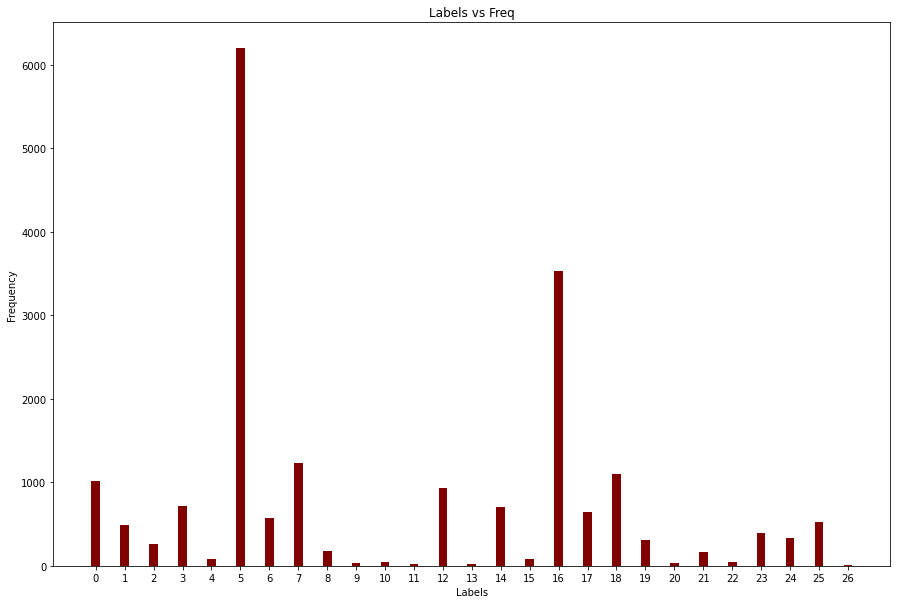

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.bar(labels, occurances, color ='maroon', width = 0.3)
plt.xticks(np.arange(0, 27, step=1))
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels vs Freq")
plt.show()

A histogram was plotted to get an idea of the sequence length of the product-description. Approximately **70%** of the data has a seq-length of **0-50**. So if one wishes to use a pre-trained Transformer model like BERT(which is true in our case) the max-seq length plays an extremely important role in the performance of the model.

In [ ]:
tempList=[]
dfTemp=dfTextMod
for i in range(len(dfTextMod)):
  temp=len(word_tokenize(dfTextMod.iloc[i,0]))
  tempList.append(temp)
dfTemp['Length']=tempList

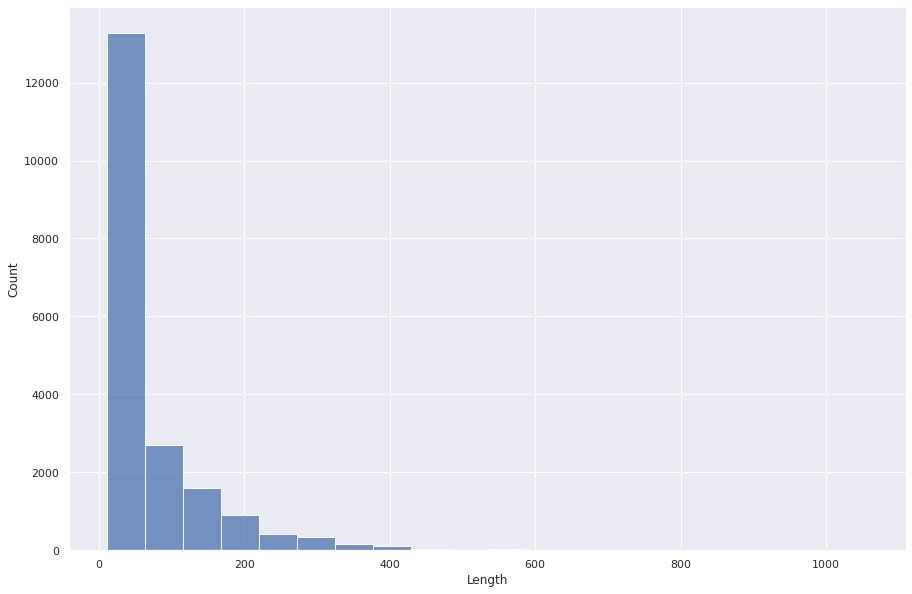

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.histplot(data=dfTemp['Length'],bins=20)